In [1]:
# Import the Required Packages
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import csv
import os

## Step 1: Data Loading

In [2]:
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
validation_dir = os.path.join(os.getcwd(), 'validation')

### VGG16 PRETRAIN MODEL Base

In [3]:
img_size = 224

from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

In [4]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### feature extraction with basic augmentation With VGG16

In [ ]:
# features shape need to follow model last layer
# Need to add a comma and 10 for labels shape as there are 10 classes for the dataset

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 7500)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 500)

In [ ]:
print(train_features.shape)
print(train_labels.shape)

In [ ]:
train_features = np.reshape(train_features, (7500, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (2000, 7 * 7 * 512))
test_features = np.reshape(test_features, (500, 7 * 7 * 512))

### Build the Model

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

vgg_base.trainable = False

vgg_2 = models.Sequential()
vgg_2.add(vgg_base)
vgg_2.add(layers.Flatten())
vgg_2.add(layers.Dense(256, activation='relu'))
vgg_2.add(layers.Dense(10, activation='softmax'))

In [6]:
vgg_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
vgg_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), # set learning rate to adam & lr of 0.001
              metrics=['acc'])

In [8]:
# Testing basic augmentations

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')


Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [9]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'vgg_augmentation_basic.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

history = vgg_2.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[mc]
)

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 1.7254 - acc: 0.4687
Epoch 1: val_loss improved from inf to 1.11152, saving model to vgg_augmentation_basic.keras
235/235 [==============================] - 109s 434ms/step - loss: 1.7254 - acc: 0.4687 - val_loss: 1.1115 - val_acc: 0.6270
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 1.1658 - acc: 0.6071
Epoch 2: val_loss improved from 1.11152 to 1.07753, saving model to vgg_augmentation_basic.keras
235/235 [==============================] - 105s 447ms/step - loss: 1.1658 - acc: 0.6071 - val_loss: 1.0775 - val_acc: 0.6435
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 1.0831 - acc: 0.6376
Epoch 3: val_loss improved from 1.07753 to 0.99708, saving model to vgg_augmentation_basic.keras
235/235 [==============================] - 111s 474ms/step - loss: 1.0831 - acc: 0.6376 - val_loss: 0.9971 - val_acc: 0.6710
Epoch 4/30
235/235 [==============================] - ETA: 0s - l

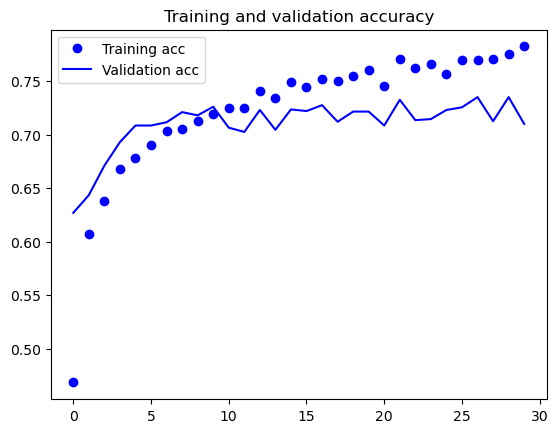

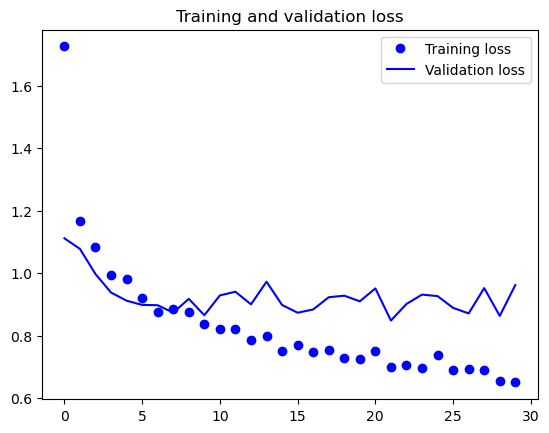

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Feature Extraction with More data augmentations by including colour and lighting

In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers

vgg_base.trainable = False

vgg_3 = models.Sequential()
vgg_3.add(vgg_base)
vgg_3.add(layers.Flatten())
vgg_3.add(layers.Dense(256, activation='relu'))
vgg_3.add(layers.Dense(10, activation='softmax'))

In [12]:
vgg_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
vgg_3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001), # set learning rate to adam & lr of 0.001
              metrics=['acc'])

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20,
    featurewise_center=False,
    featurewise_std_normalization=False, 
    preprocessing_function=None
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')


validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [15]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'vgg_augmentation_advanced.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)

history = vgg_3.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[mc]
)

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 1.8369 - acc: 0.4481
Epoch 1: val_loss improved from inf to 1.16407, saving model to vgg_augmentation_advanced.keras
235/235 [==============================] - 95s 401ms/step - loss: 1.8369 - acc: 0.4481 - val_loss: 1.1641 - val_acc: 0.6095
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 1.1933 - acc: 0.5971
Epoch 2: val_loss improved from 1.16407 to 1.00388, saving model to vgg_augmentation_advanced.keras
235/235 [==============================] - 98s 417ms/step - loss: 1.1933 - acc: 0.5971 - val_loss: 1.0039 - val_acc: 0.6620
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 1.1036 - acc: 0.6359
Epoch 3: val_loss improved from 1.00388 to 0.95157, saving model to vgg_augmentation_advanced.keras
235/235 [==============================] - 97s 410ms/step - loss: 1.1036 - acc: 0.6359 - val_loss: 0.9516 - val_acc: 0.6905
Epoch 4/30
235/235 [==============================] - ETA: 

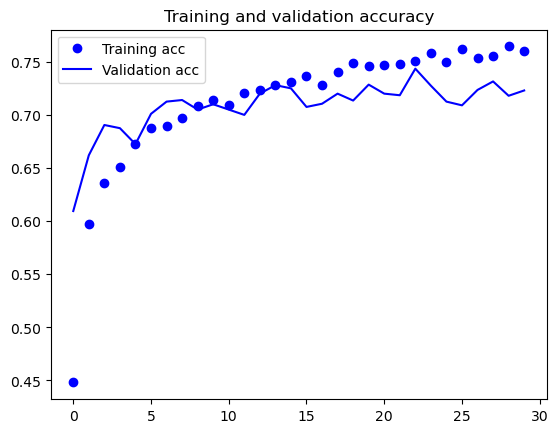

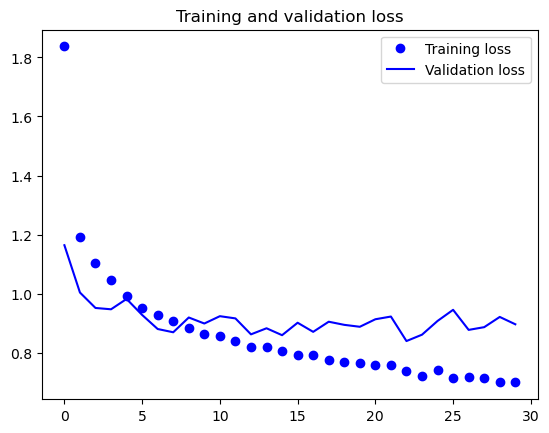

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()